In [1]:
import tarfile
import os
import skimage.io
import matplotlib.pyplot as plt 
import cv2
import numpy as np

data_base_path = os.path.join(os.pardir, 'Image_processing/train_games')
data_folder = 'game2'


%matplotlib inline



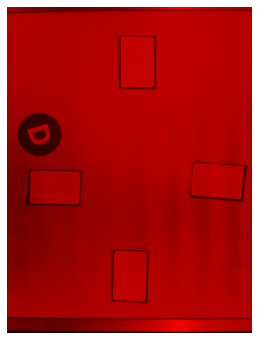

In [2]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
Im = skimage.io.imread(os.path.join(data_path, '3.jpg'))
im_h,im_w,_=Im.shape
# Display card image
Im[:,:,2]=0    
Im[:,:,1]=0 
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(Im)
ax.axis('off')
plt.show()

In [3]:
def load_image_from_game(folder):
    data_base_path = os.path.join(os.pardir, 'Image_processing/train_games')
    data_folder = folder
    digit_names = [nm for nm in os.listdir(data_path) if '.jpg' in nm]  # make sure to only load .png
    digit_names.sort(key = lambda x: (len (x), x))  # sort file names

    ic = skimage.io.imread_collection([os.path.join(data_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)

    nb_digit,digit_im_h,digit_im_w,color_channels=digit_im.shape
    return nb_digit,digit_names, digit_im


In [4]:
def display_im(digit_names,digit_im,plot_every):
    for idx in range(0,nb_digit,plot_every):
        # Display MRI image
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(digit_im[idx])
        ax.set_title('game im : {}'.format(digit_names[idx]))
        ax.axis('off')
        plt.show()

In [27]:
def find_cnts(nb_digit,digit_im,disp=False,edge_threshold=110,Kernel_opening=(20,20),ker_dilate=(3,3),
             dilate_iteration=3):
    cnts=[]
    for idx in range(0,nb_digit):

        #digit_filtered = cv2.GaussianBlur(digit_im[idx],(5,5),cv2.BORDER_DEFAULT)
        ret, thresh = cv2.threshold(digit_im[idx], edge_threshold, 255, cv2.THRESH_BINARY_INV)

        #noise del
        K_op=(20,20)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, Kernel_opening)

        #It simply consist of a Dilation followed by Erosion
        #we chosed a kernel of dimension 3 to avoid altering the image too much
        k1 = np.ones(ker_dilate)
        erode = cv2.dilate(thresh,k1,iterations = dilate_iteration)

        #find_contours in red 
        cnts_buf,_ = cv2.findContours(erode[:,:,0],cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

        cntsSorted = sorted(cnts_buf, key=lambda x: cv2.contourArea(x),reverse=True)
        cnts.append(cntsSorted)
        
        if(disp==True):
            # Display image
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            ax.imshow(erode[:,:,0], cmap='gray')
            ax.set_title('im {},jpg'.format(idx))
            ax.axis('off')
            plt.show()
        
    return cnts




In [22]:
#copy of the image as the function modify the input image

def compute_card_area(cnts,digit_im,disp=False):
    """
    output : card_pos [nb_game,card_nb,[start_x, start_y, height, width]]
    """
    card_pos=[]
    for game_idx in range (0,13):
        round_idx=game_idx
        Im_cop=np.copy(digit_im[round_idx])
        card_pos_buf=[]
        for i in range(0,4):
            x,y,w,h=cv2.boundingRect(cnts[round_idx][i])
            card_pos_buf.append([x,y,w,h])
            img=cv2.rectangle(Im_cop,(x,y),(x+w,y+h),(255,0,255),20)
        
        card_pos.append(card_pos_buf)

        if disp==True :
            # Display img image
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            ax.imshow(img)
            ax.set_title('im {}.jpg'.format(round_idx))
            ax.axis('off')
            plt.show()
    return card_pos

In [7]:
    
        

def get_players_id(card_pos,im_w,im_h):
    y=1
    x=0
    card_pos_sort=[]
    for game_idx in range(0,13):
        #set to lower left pos
        right_card=[im_h/2,0,0,0]
        #set to upper left pos
        left_card=[im_h/2,0,0,0]
        #set to upper left pos
        lower_card=[0,im_w/2,0,0]
        #set to upper right pos
        upper_card=[0,im_w/2,0,0]
        #We do 2 comparison to avoid wrong classification
        for identification in range(0,2):
            for card_idx in range(0,4):
                #to visualize logic, [0,0] is at upper left
                if (card_pos[game_idx][card_idx][x]>=right_card[x]):
                    right_card=card_pos[game_idx][card_idx] 
                if (card_pos[game_idx][card_idx][x]<=left_card[x]):
                    left_card=card_pos[game_idx][card_idx]  
                if (card_pos[game_idx][card_idx][y]>=lower_card[y]):
                    lower_card=card_pos[game_idx][card_idx] 
                if (card_pos[game_idx][card_idx][y]<=upper_card[y]):
                    upper_card=card_pos[game_idx][card_idx] 
                    
        card_pos_sort.append([lower_card,left_card,upper_card,right_card])
    return card_pos_sort

        
            

In [8]:
def retrieve_cards(card_pos,digit_im,disp=False):
    
    pos_name=["lower_card","left_card","upper_card","right_card"]
    retrieved_cards=[]
    for game_idx in range(0,13):
        cards_images=[]
        for card_idx in range(0,4):
            card_im=digit_im[game_idx,
                            card_pos[game_idx][card_idx][1]:card_pos[game_idx][card_idx][1]+card_pos[game_idx][card_idx][3],
                            card_pos[game_idx][card_idx][0]:card_pos[game_idx][card_idx][0]+card_pos[game_idx][card_idx][2]]
            #rotate in desired position
            if (card_idx==1):
                card_im = cv2.rotate(card_im, cv2.ROTATE_90_COUNTERCLOCKWISE) 
            if (card_idx==2):
                card_im = cv2.rotate(card_im, cv2.ROTATE_180) 
            if (card_idx==3):
                card_im = cv2.rotate(card_im, cv2.ROTATE_90_CLOCKWISE) 

            cards_images.append(card_im)

            if disp==True:
                print('Round:',game_idx)
                fig, ax = plt.subplots(1, 1, figsize=(6, 6))
                ax.imshow(card_im)
                ax.set_title('{}.jpg'.format(pos_name[card_idx]))
                ax.axis('off')
                plt.show()
        retrieved_cards.append(cards_images)
    return retrieved_cards
    


Round: 0


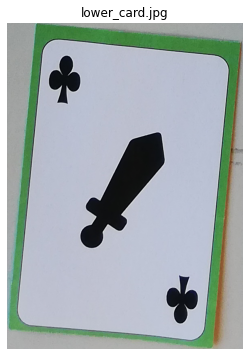

Round: 0


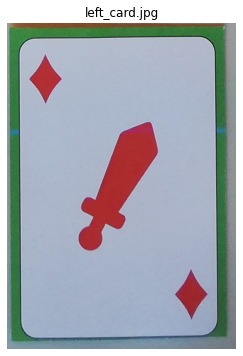

Round: 0


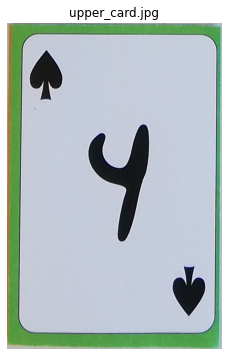

Round: 0


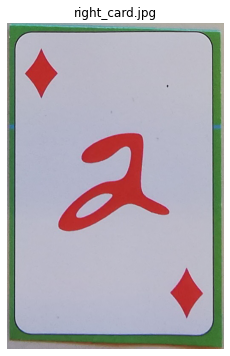

Round: 1


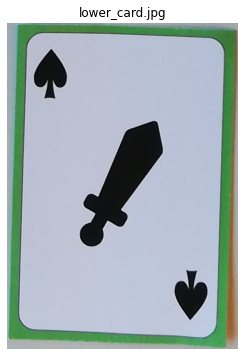

Round: 1


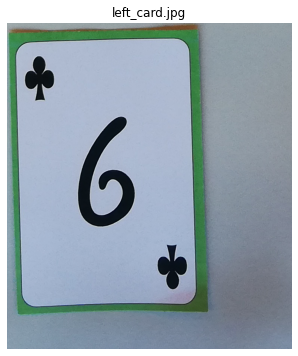

Round: 1


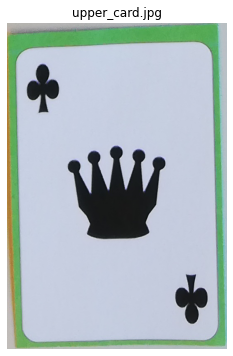

Round: 1


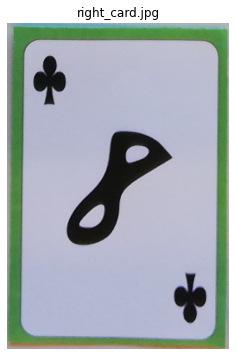

Round: 2


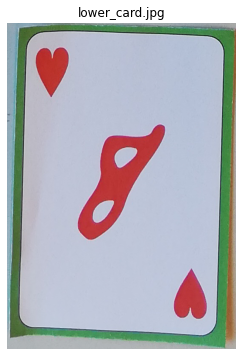

Round: 2


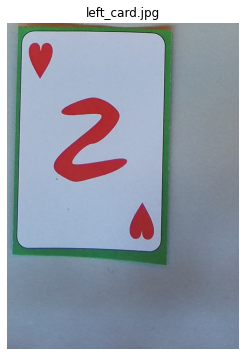

Round: 2


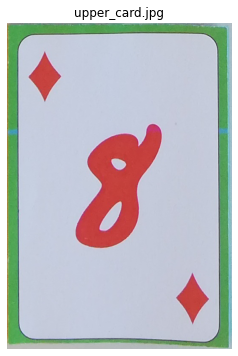

Round: 2


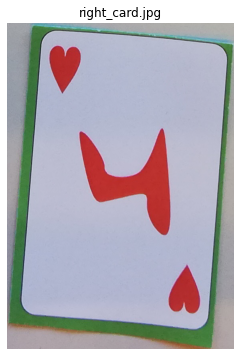

Round: 3


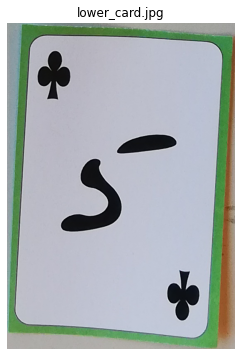

Round: 3


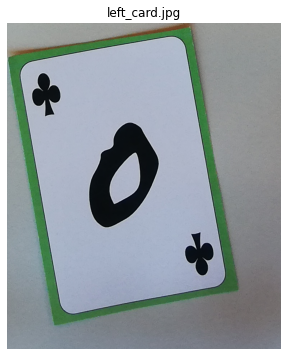

Round: 3


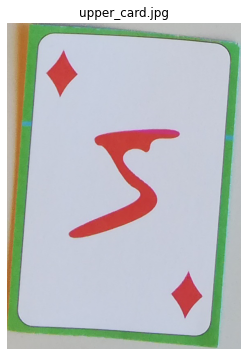

Round: 3


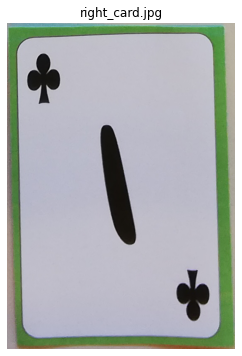

Round: 4


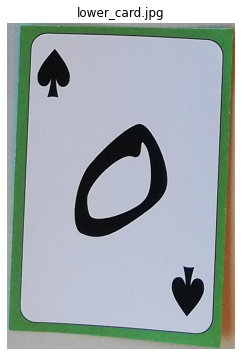

Round: 4


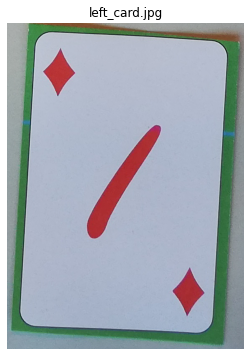

Round: 4


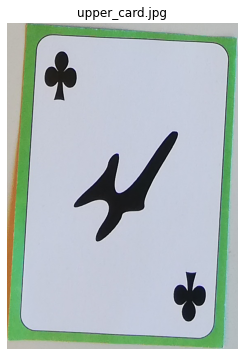

Round: 4


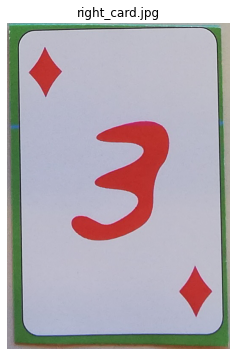

Round: 5


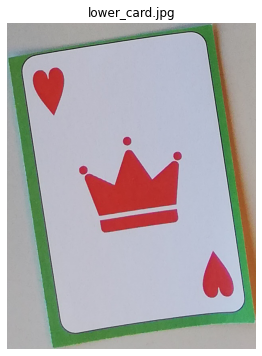

Round: 5


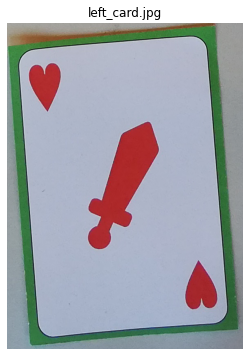

Round: 5


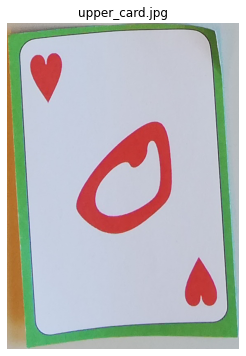

Round: 5


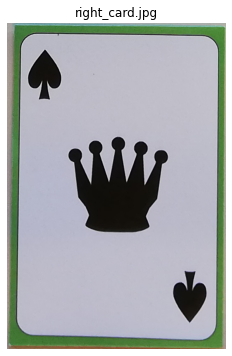

Round: 6


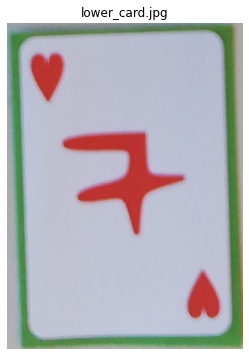

Round: 6


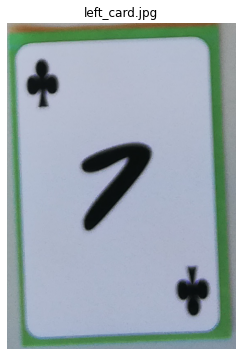

Round: 6


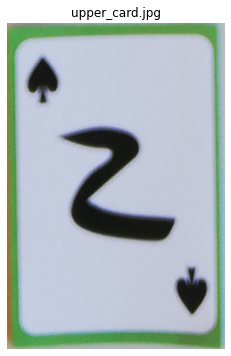

Round: 6


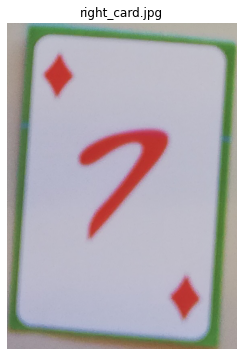

Round: 7


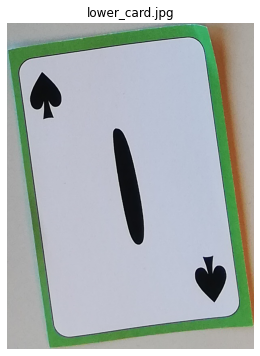

Round: 7


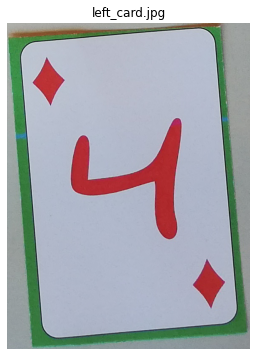

Round: 7


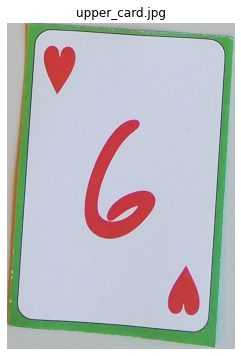

Round: 7


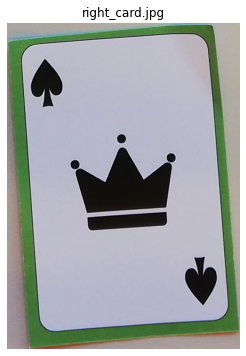

Round: 8


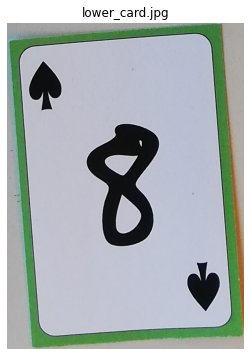

Round: 8


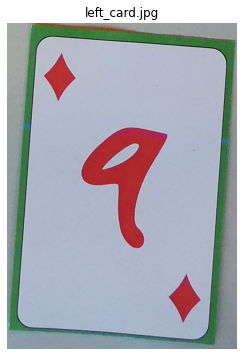

Round: 8


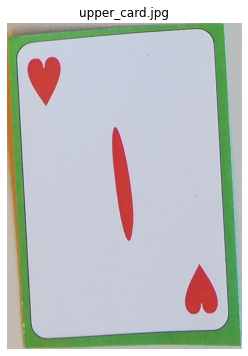

Round: 8


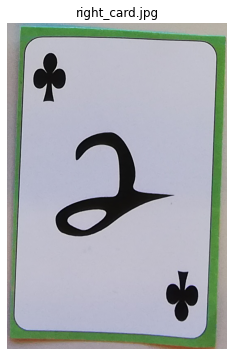

Round: 9


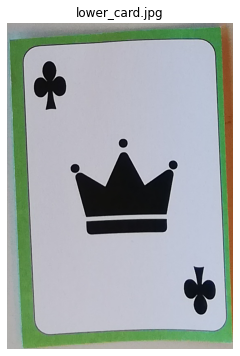

Round: 9


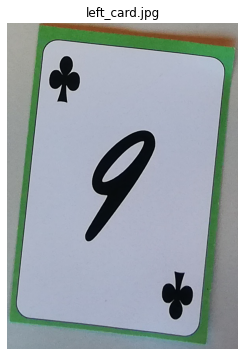

Round: 9


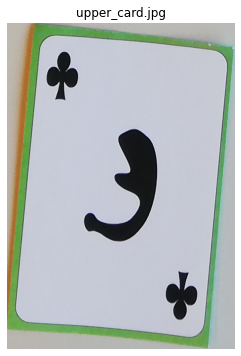

Round: 9


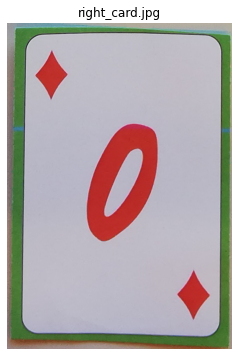

Round: 10


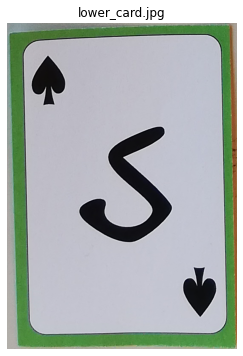

Round: 10


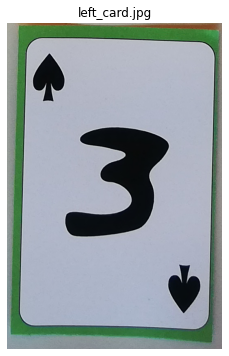

Round: 10


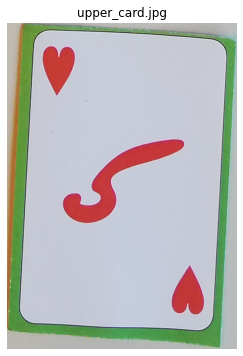

Round: 10


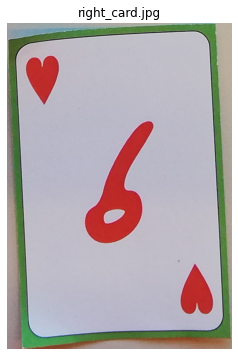

Round: 11


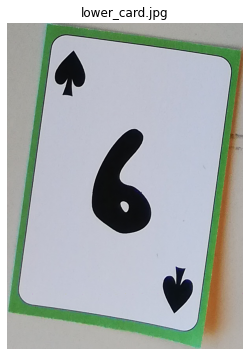

Round: 11


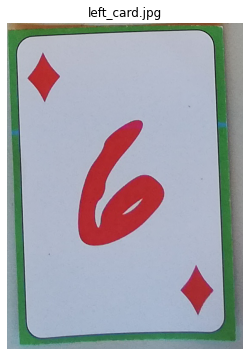

Round: 11


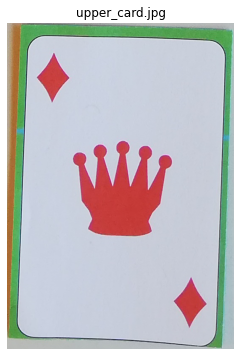

Round: 11


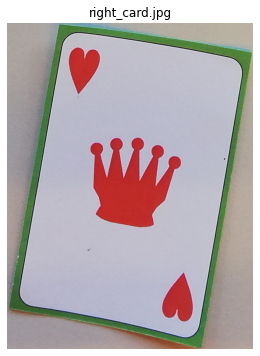

Round: 12


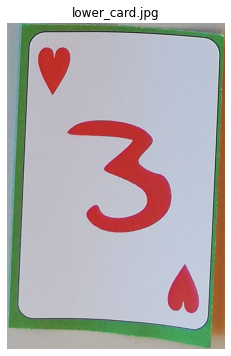

Round: 12


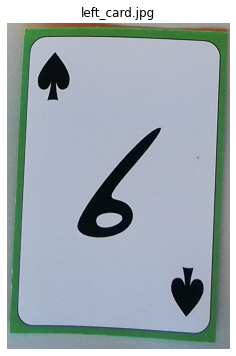

Round: 12


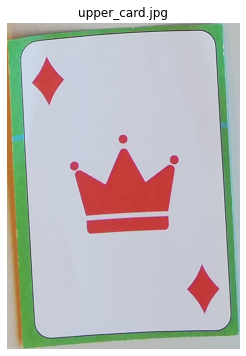

Round: 12


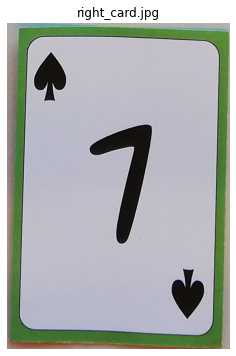

In [28]:
nb_digit,digit_names,digit_im=load_image_from_game('game7')
im_h,im_w,_=digit_im[0].shape

#plot orignal images
#display_im(digit_names,digit_im,3)

#compute contours of card 
cnts=find_cnts(nb_digit,digit_im)

#locate_cards dim 
card_pos=compute_card_area(cnts,digit_im)

#sorted card by their position
card_pos_sorted=get_players_id(card_pos,im_w,im_h)

#Retrieve only area of interest
retrieved_cards=retrieve_cards(card_pos_sorted,digit_im,disp=True)
